In [1]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [2]:
import PIL
from PIL import Image,ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter
import os
import shutil
import random
import cv2

/data/aglinska/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
def inflate_mask(mask,radius=5):
    mask_temp = Image.fromarray(mask).filter(ImageFilter.GaussianBlur(radius))
    mask_temp = np.array(mask_temp)
    mask_temp[mask_temp>0]=255
    return mask_temp

In [4]:
import skvideo
import skvideo.io

def load_video(fn):
    videodata = skvideo.io.vread(fn)
    return videodata

In [5]:
def plot_video(arr):
    
    if arr.ndim<4:
        arr = arr[:,:,:,np.newaxis]
        
    nframes = arr.shape[0]
    plt.figure(figsize=(15,5))
    for c,i in enumerate(np.floor(np.linspace(0,nframes-1,5))):
        plt.subplot(1,5,c+1)
        plt.axis('off')
        plt.imshow(arr[int(i),:,:,0:3])
    plt.show()

In [6]:
indir = '~/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4'
indir = os.path.expanduser(indir)
indir

'/data/aglinska/BC-actionpred-seg/Data/haa500_v1_1_yolo_seg4'

In [7]:
folders = [folder for folder in os.listdir(indir) if not folder.startswith('.')]
folders.sort()
n = len(folders)
print(n)
folders[0:3]

499


['ALS_IceBucket_Challenge', 'CPR', 'abseiling']

In [8]:
fn_temp = '{indir}/{folder}/{folder}_{video}_item_0_masks.npy'

In [9]:
check_arr = np.zeros((20,len(folders)))
for f in tqdm(range(n)):
    for v in range(20):
        fn = fn_temp.format(indir=indir,folder=folders[f],video=f'{v:03d}')
        check_arr[v,f] = os.path.exists(fn)

100%|█████████████████████████████████████████████████████████████████████████████████| 499/499 [00:07<00:00, 69.11it/s]


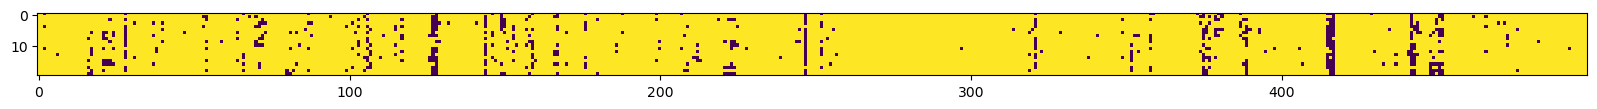

In [10]:
plt.figure(figsize=np.array((10,5))*2)
plt.imshow(check_arr)

In [11]:
print(f'{check_arr.mean():.2f}, {check_arr.sum()}/{np.prod(check_arr.shape)}')

0.94, 9371.0/9980


In [16]:
not_done = []
for f in range(check_arr.shape[1]):
    for v in range(check_arr.shape[0]):
        if check_arr[v,f]==0:
            not_done.append((f,v))      
print(np.array(not_done).shape)
np.array(not_done)[0:5,:] # Mostly frame mismatch

(609, 2)


array([[ 2,  0],
       [ 2,  4],
       [ 2, 11],
       [ 6, 13],
       [16,  8]])

In [151]:
arr_ss = np.zeros(check_arr.shape)
arr_e_frames = np.zeros(check_arr.shape)

for f in tqdm(range(n)):
    for v in range(20):
        if bool(check_arr[v,f]):
            fn = fn_temp.format(indir=indir,folder=folders[f],video=f'{v:03d}')
            mask = np.load(fn)
            
            ss = mask.sum(-1).sum(-1)
            ss=ss/ss[0]
            
            arr_ss[v,f] = ss.std()
            arr_e_frames[v,f] = (np.array([mask[i,:,:].sum() for i in range(mask.shape[0])])<10).sum()
            arr_e_frames[v,f] = arr_e_frames[v,f]/mask.shape[0]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 499/499 [06:59<00:00,  1.19it/s]


In [154]:
(arr_e_frames>.10).sum()

775

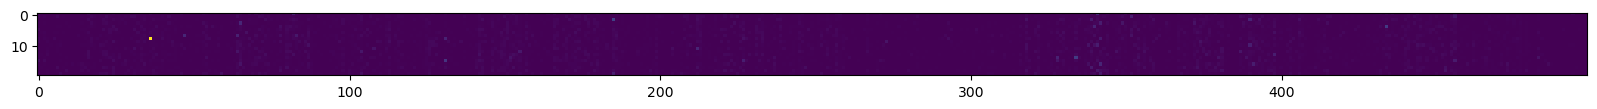

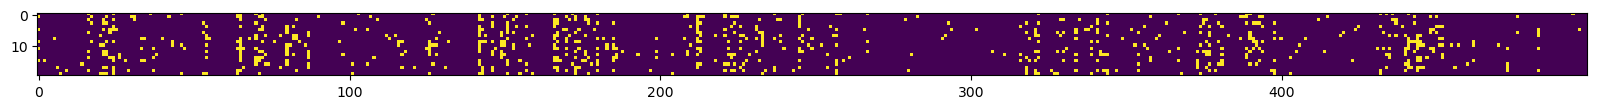

In [155]:
plt.figure(figsize=np.array((10,5))*2)
plt.imshow(arr_ss)

plt.figure(figsize=np.array((10,5))*2)
plt.imshow(arr_e_frames>.1)

<AxesSubplot:ylabel='Count'>

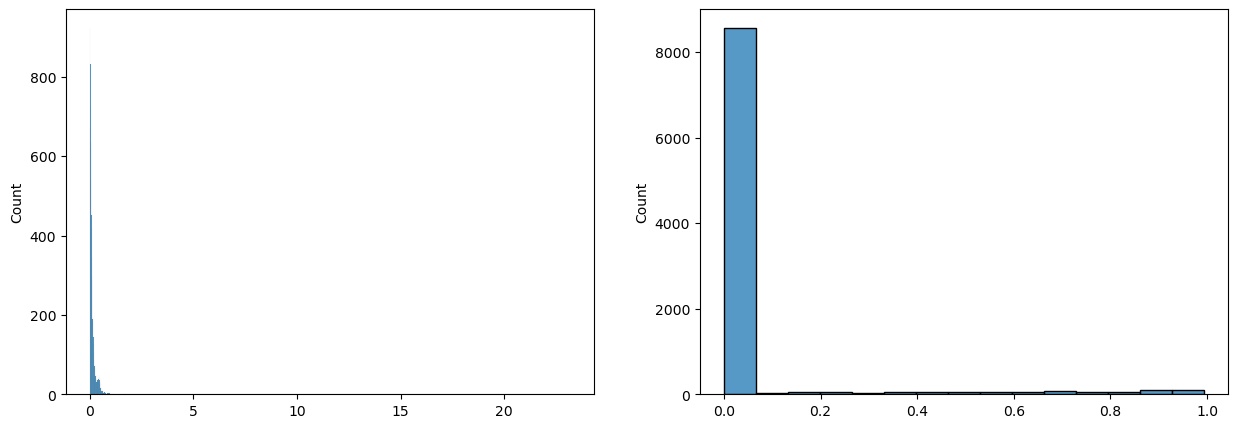

In [196]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1);sns.histplot(arr_ss[check_arr.astype(np.bool_)].flatten())
plt.subplot(1,2,2);sns.histplot(arr_e_frames[check_arr.astype(np.bool_)].flatten())

In [166]:
(arr_e_frames>0).sum()

838

In [189]:
### Check empty frames
temp = []
for f in range(arr_e_frames.shape[1]):
    for v in range(arr_e_frames.shape[0]):
        if arr_e_frames[v,f]>.5:
            temp.append((f,v))
temp = np.array(temp)
print(temp.shape)
temp[np.random.randint(0,temp.shape[0],10),:] # Mostly frame mismatch

(518, 2)


array([[ 34,   8],
       [228,  15],
       [318,  18],
       [186,  14],
       [441,   8],
       [390,   8],
       [393,   1],
       [470,  10],
       [218,  15],
       [146,   3]])

In [157]:
arr_e_frames.shape

(20, 499)

0.9607843137254902


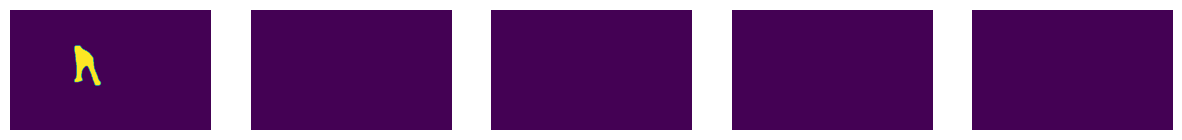

In [192]:
f = 34,v = 8
fn = fn_temp.format(indir=indir,folder=folders[f],video=f'{v:03d}')
print(arr_e_frames[v,f])
mask = np.load(fn)
plot_video(mask)

0.5294117647058824


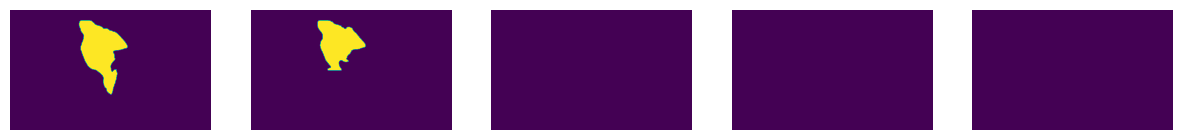

In [194]:
f = 228;v = 15
fn = fn_temp.format(indir=indir,folder=folders[f],video=f'{v:03d}')
print(arr_e_frames[v,f])
mask = np.load(fn)
plot_video(mask)

0.6470588235294118


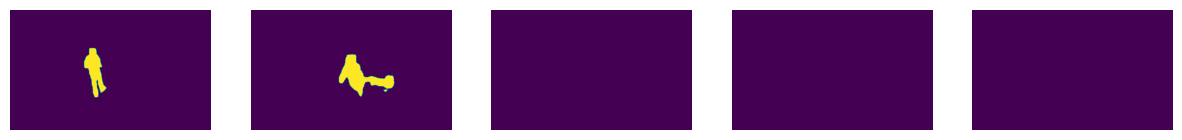

In [195]:
f = 318;v = 18
fn = fn_temp.format(indir=indir,folder=folders[f],video=f'{v:03d}')
print(arr_e_frames[v,f])
mask = np.load(fn)
plot_video(mask)

In [197]:
### Check SS values
temp = []
for f in range(arr_ss.shape[1]):
    for v in range(arr_ss.shape[0]):
        if arr_ss[v,f]>5:
            temp.append((f,v))
temp = np.array(temp)
print(temp.shape)
#temp[np.random.randint(0,temp.shape[0],10),:]
temp[:,:]

(1, 2)


array([[36,  8]])

0.0


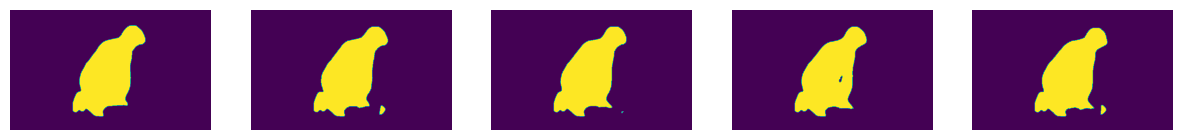

In [199]:
f = 1;v = 2
fn = fn_temp.format(indir=indir,folder=folders[f],video=f'{v:03d}')
print(arr_e_frames[v,f])
mask = np.load(fn)
plot_video(mask)

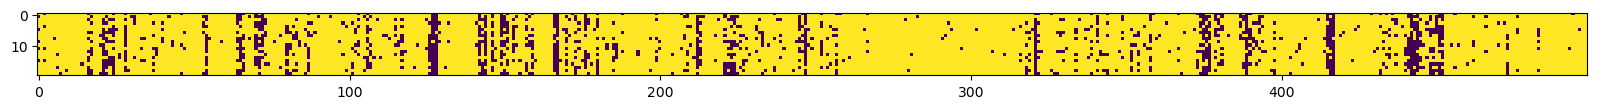

In [207]:
good_videos = check_arr * (arr_e_frames==0)

plt.figure(figsize=np.array((10,5))*2)
plt.imshow(good_videos);

In [208]:
print(f'{good_videos.mean():.2f}, {good_videos.sum()}/{np.prod(good_videos.shape)}')

0.86, 8533.0/9980


In [210]:
bool(good_videos[v,f])

True

In [237]:
masks = []
for f in tqdm(range(good_videos.shape[1])):
    for v in range(good_videos.shape[0]):
        if bool(good_videos[v,f])==True:
            fn = fn_temp.format(indir=indir,folder=folders[f],video=f'{v:03d}')
            mask = np.load(fn)
            mask_inflated = inflate_mask((( mask.sum(axis=0) >0 )*255).astype(np.uint8),radius=15)
            masks.append(mask_inflated)
masks = np.array(masks)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 499/499 [06:10<00:00,  1.35it/s]


In [238]:
masks.shape

(8533, 384, 640)

In [256]:
perc = [(masks[i,:,:]==255).sum() / np.prod(masks.shape[1::]) for i in range(masks.shape[0])]

<AxesSubplot:ylabel='Count'>

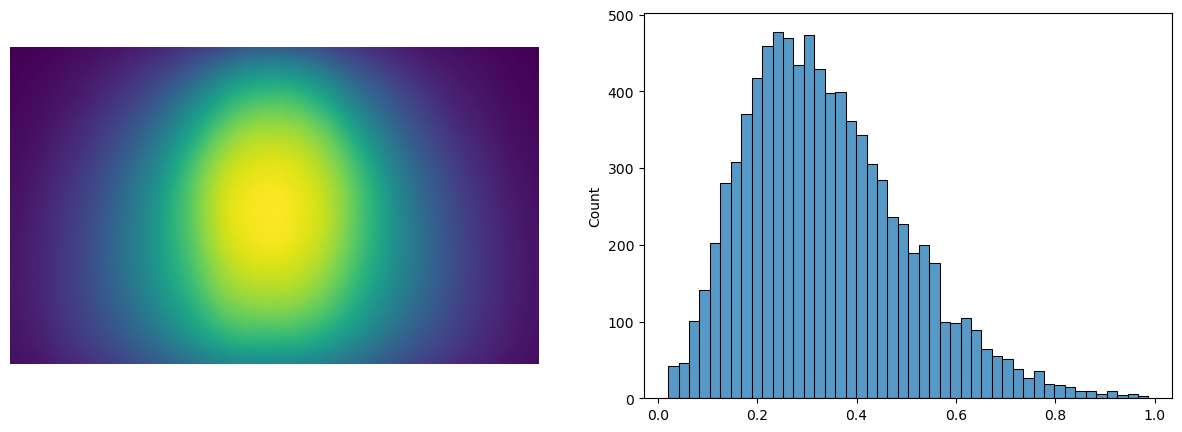

In [257]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1);plt.imshow(masks.mean(axis=0));plt.axis('off')
plt.subplot(1,2,2);sns.histplot(perc)

In [259]:
np.save('good_videos.npy',good_videos)

In [229]:
# filled_spots = np.repeat(False,len(where_fits))
# spots_found_for = np.repeat(False,len(where_fits))

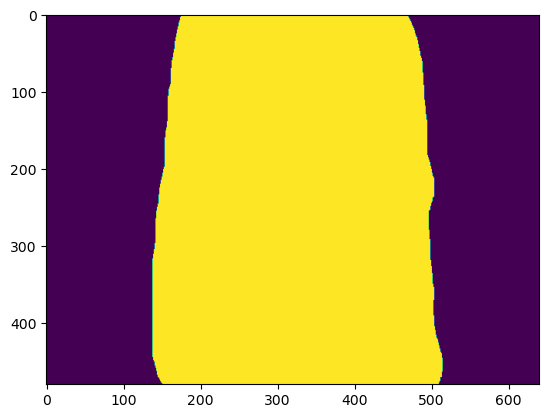

In [237]:
# 80
i = 0
this_mask = col_masks[i]
plt.imshow(this_mask)

In [238]:
where_fits = np.array([not (col_masks[j].astype(float)+this_mask.astype(float)).max()>255 for j in tqdm(range(len(col_masks)))])

100%|█████████████████████████████████████████████████████████████████████████████| 9120/9120 [00:08<00:00, 1129.27it/s]


In [239]:
where_fits.sum()

129

In [241]:
where_fits_idx = np.nonzero(where_fits)[0]

In [252]:
#temp = np.argmin([(this_mask+col_masks[j]==0).sum() for j in where_fits_idx])
temp = np.argsort([(this_mask+col_masks[j]==0).sum() for j in where_fits_idx])[0]
where_fits_choose = where_fits_idx[temp]

(-0.5, 639.5, 479.5, -0.5)

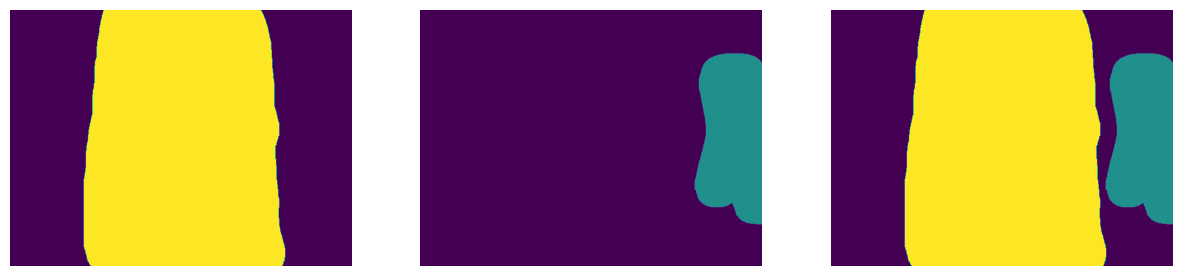

In [251]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1);plt.imshow(this_mask,vmin=0,vmax=255);plt.axis('off')
plt.subplot(1,3,2);plt.imshow(col_masks[where_fits_choose]/2,vmin=0,vmax=255);plt.axis('off')
plt.subplot(1,3,3);plt.imshow(this_mask+col_masks[where_fits_choose]/2,vmin=0,vmax=255);plt.axis('off')

In [215]:
def plot_triple(mask1,mask2):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1);plt.imshow(mask1,vmin=0,vmax=255);plt.axis('off')
    plt.subplot(1,3,2);plt.imshow(mask2/2,vmin=0,vmax=255);plt.axis('off')
    plt.subplot(1,3,3);plt.imshow(mask1+mask2/2,vmin=0,vmax=255);plt.axis('off')

In [214]:
filled_spots = np.repeat(False,len(where_fits))
spots_found_for = np.repeat(False,len(where_fits))
where_to_inpaint_idx = np.zeros(len(where_fits))

for i in tqdm(range(10)):
        
    this_mask = col_masks[i] # Take a mask
    where_fits = np.array([not (col_masks[j].astype(float)+this_mask.astype(float)).max()>255 for j in range(len(col_masks))]) # Find where it would fit
    
    where_fits[filled_spots]=False # Make sure not already filles

    if where_fits.sum()>0:
        where_fits_idx = np.nonzero(where_fits)[0]
        temp = np.argsort([(this_mask+col_masks[j]==0).sum() for j in where_fits_idx])[0]
        where_fits_choose = where_fits_idx[temp]
        
        filled_spots[where_fits_choose] = True
        spots_found_for[i]=True
        where_to_inpaint_idx[i] = where_fits_choose

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:10<00:00,  7.00s/it]


In [232]:
spots_found_for

array([ True,  True,  True, ..., False, False, False])

In [233]:
where_to_inpaint_idx

array([ 292., 1894., 5019., ...,    0.,    0.,    0.])

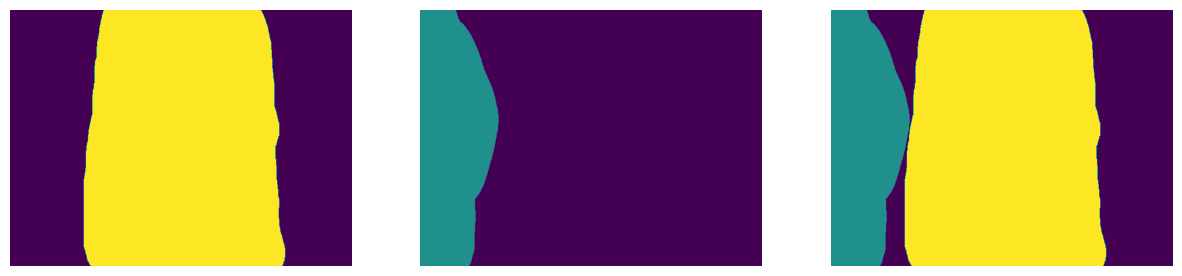

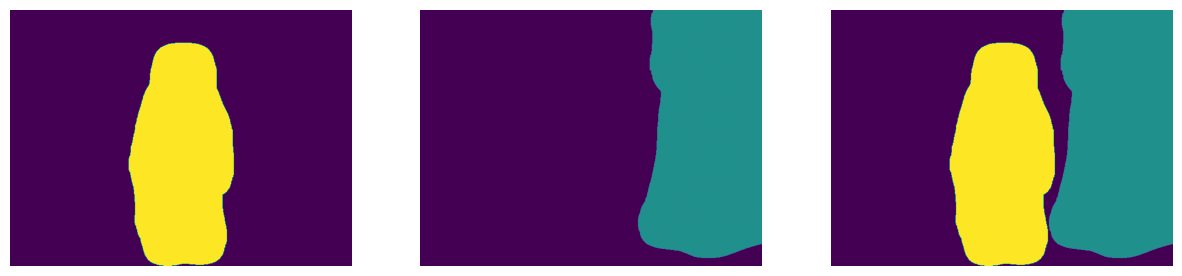

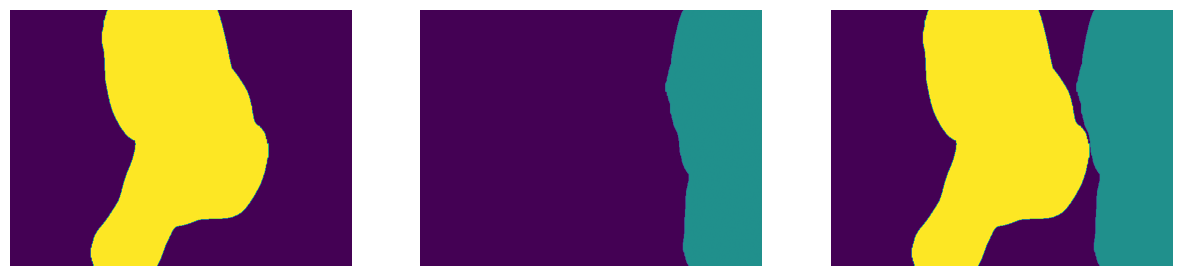

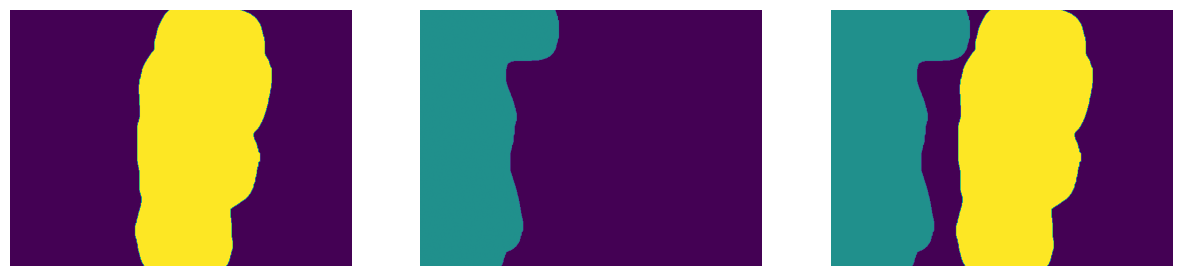

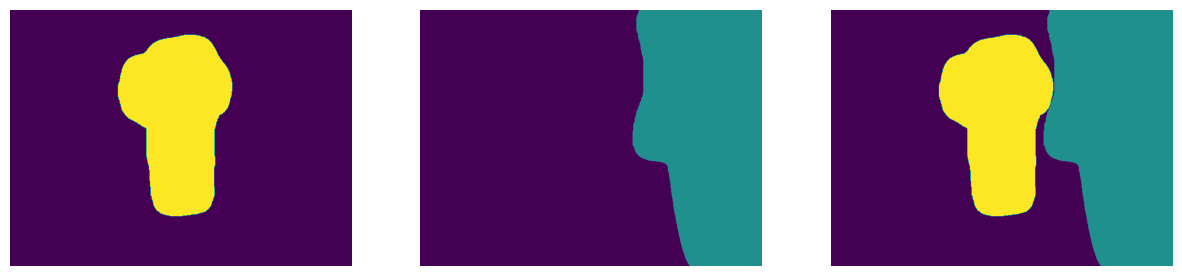

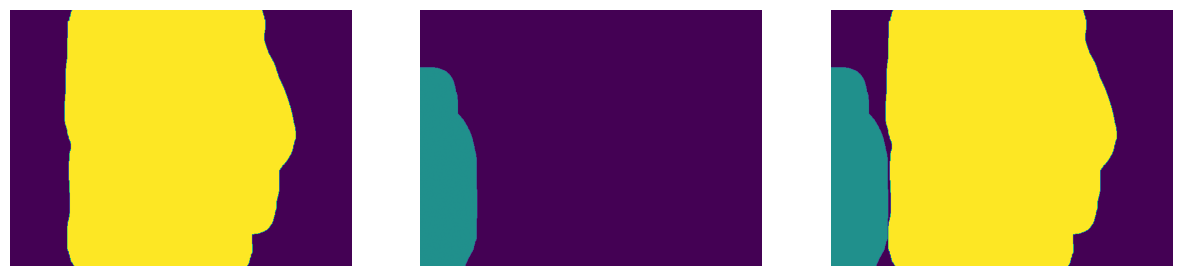

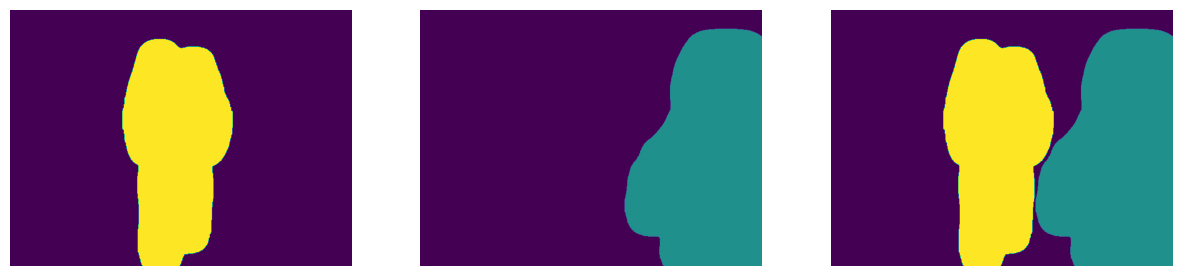

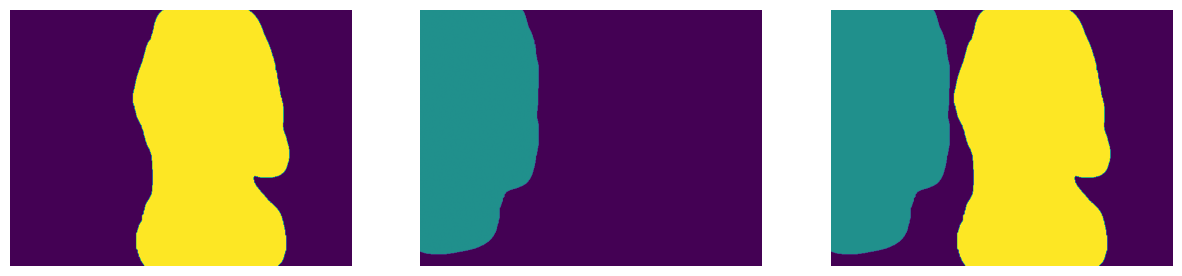

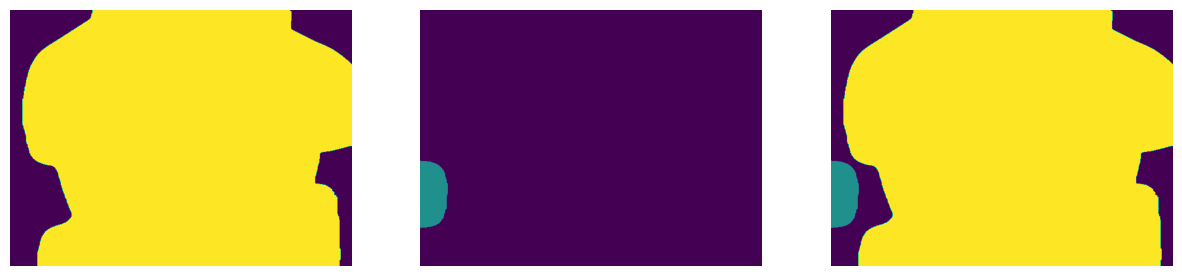

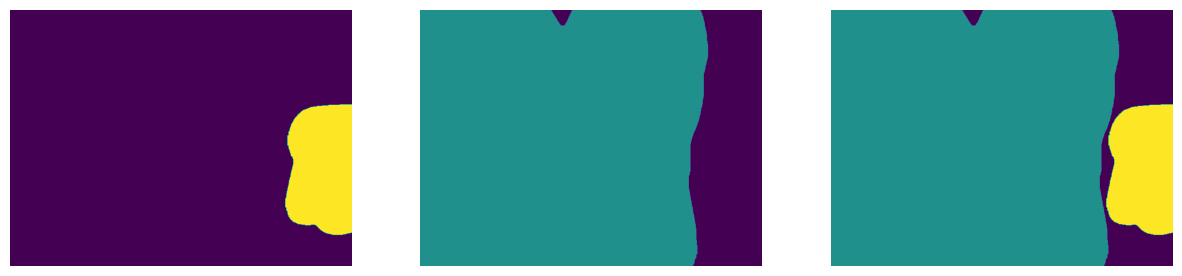

In [222]:
for i in range(10):
    plot_triple(col_masks[i],col_masks[int(where_to_inpaint_idx[i])])

### TODOS
 - ~simple algo~
 - ~simple algo loop~
 - QA videos 
 - Resizing of the videos
 - Jiggle masks
 - Account for inpainting radius
 - Make sure inpainting in a different action category?
 - for missed frames, use the last good frame?
 - video duration plot
 - long videos can cut?
 - video size plot
 - average size and width
 - get the code form Hamed